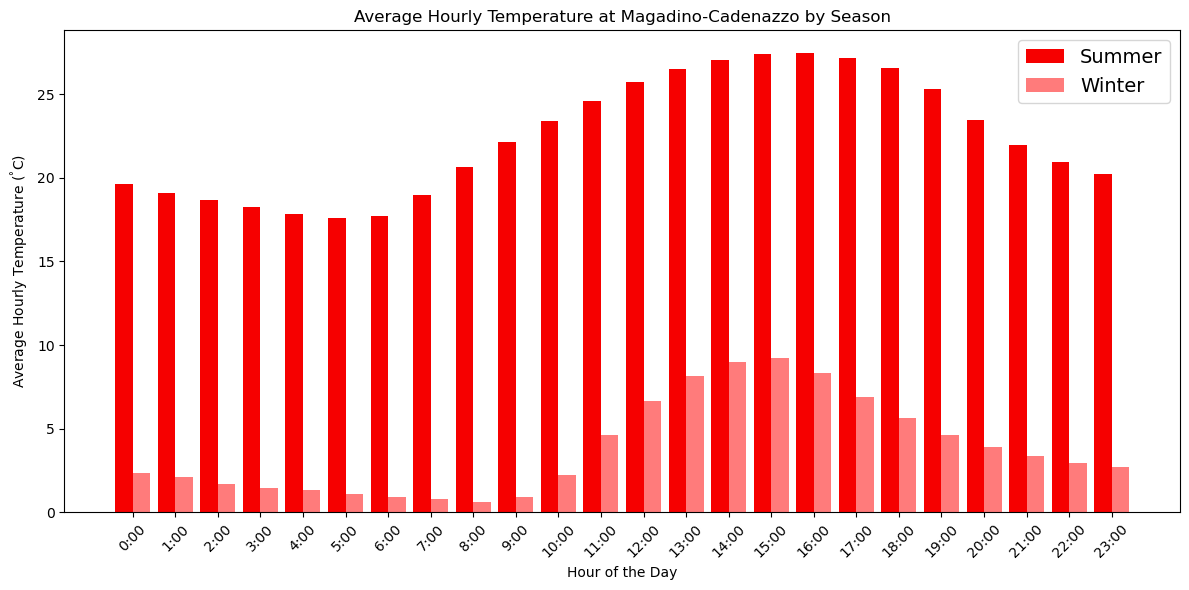

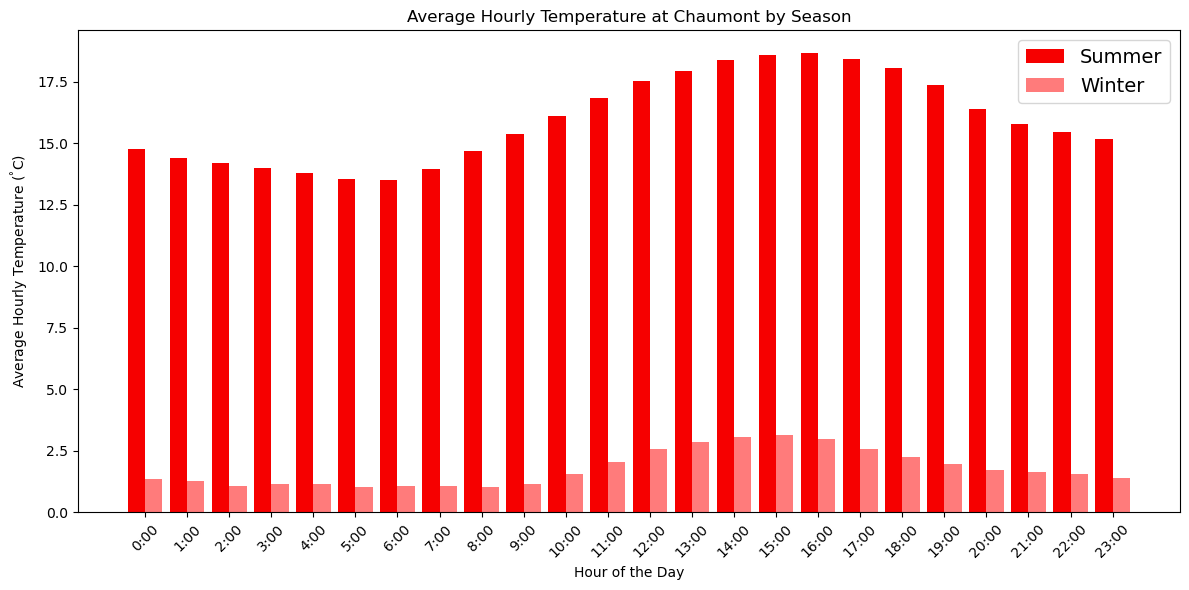

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import colorsys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

plt.rcParams['legend.fontsize'] = 14  # Sets the default legend font size to 14 points

# Extract the pollutant name from the filename
pollutant_name = Path(file_path).stem

# Step 1: Load the data
file_path = 'TEMP.csv'  # Replace with your actual file path
df = pd.read_csv(file_path, delimiter=';', parse_dates=['Date/heure'], dayfirst=True)
df.set_index('Date/heure', inplace=True)

# Step 2: Define seasons
# Assuming winter is from December to February and summer is from June to August
df['Season'] = np.where(df.index.month.isin([12, 1, 2]), 'Winter',
                        np.where(df.index.month.isin([6, 7, 8]), 'Summer', 'Other'))

# Step 3: Filter out only summer and winter data
df_seasonal = df[df['Season'] != 'Other']

# Step 4: Calculate hourly averages for each season and station
hourly_means = df_seasonal.groupby([df_seasonal.index.hour, 'Season']).mean().unstack()

# Step 5: Function to lighten a color
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by reducing its saturation and increasing its lightness.
    Input can be a matplotlib color string, hex string, or RGB tuple.
    """
    try:
        c = mcolors.cnames[color]
    except KeyError:
        c = color
    rgb = mcolors.to_rgb(c)
    hls = colorsys.rgb_to_hls(*rgb)
    lighter_rgb = colorsys.hls_to_rgb(hls[0], 1 - amount * (1 - hls[1]), hls[2])
    return lighter_rgb

# Step 6: Plotting
base_color = '#F60000'  # Default base color
lighter_color = lighten_color(base_color, 0.5)

for station in ['Magadino-Cadenazzo', 'Chaumont']:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Data for plotting
    indices = np.arange(24)
    summer_means = hourly_means[station]['Summer'].values
    winter_means = hourly_means[station]['Winter'].values
    
    # Bar width and spacing
    bar_width = 0.35
    spacing = 0.15
    total_width = 2 * bar_width + spacing
    positions = indices * total_width
    
    # Plot bars
    ax.bar(positions, summer_means, width=bar_width, color=base_color, label='Summer')
    ax.bar(positions + bar_width, winter_means, width=bar_width, color=lighter_color, label='Winter')
    
    # Formatting the plot
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Average Hourly Temperature ($^°$C)')
    ax.set_title(f'Average Hourly Temperature at {station} by Season')
    ax.set_xticks(positions + bar_width / 2)
    ax.set_xticklabels([f'{h}:00' for h in range(24)], rotation=45)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

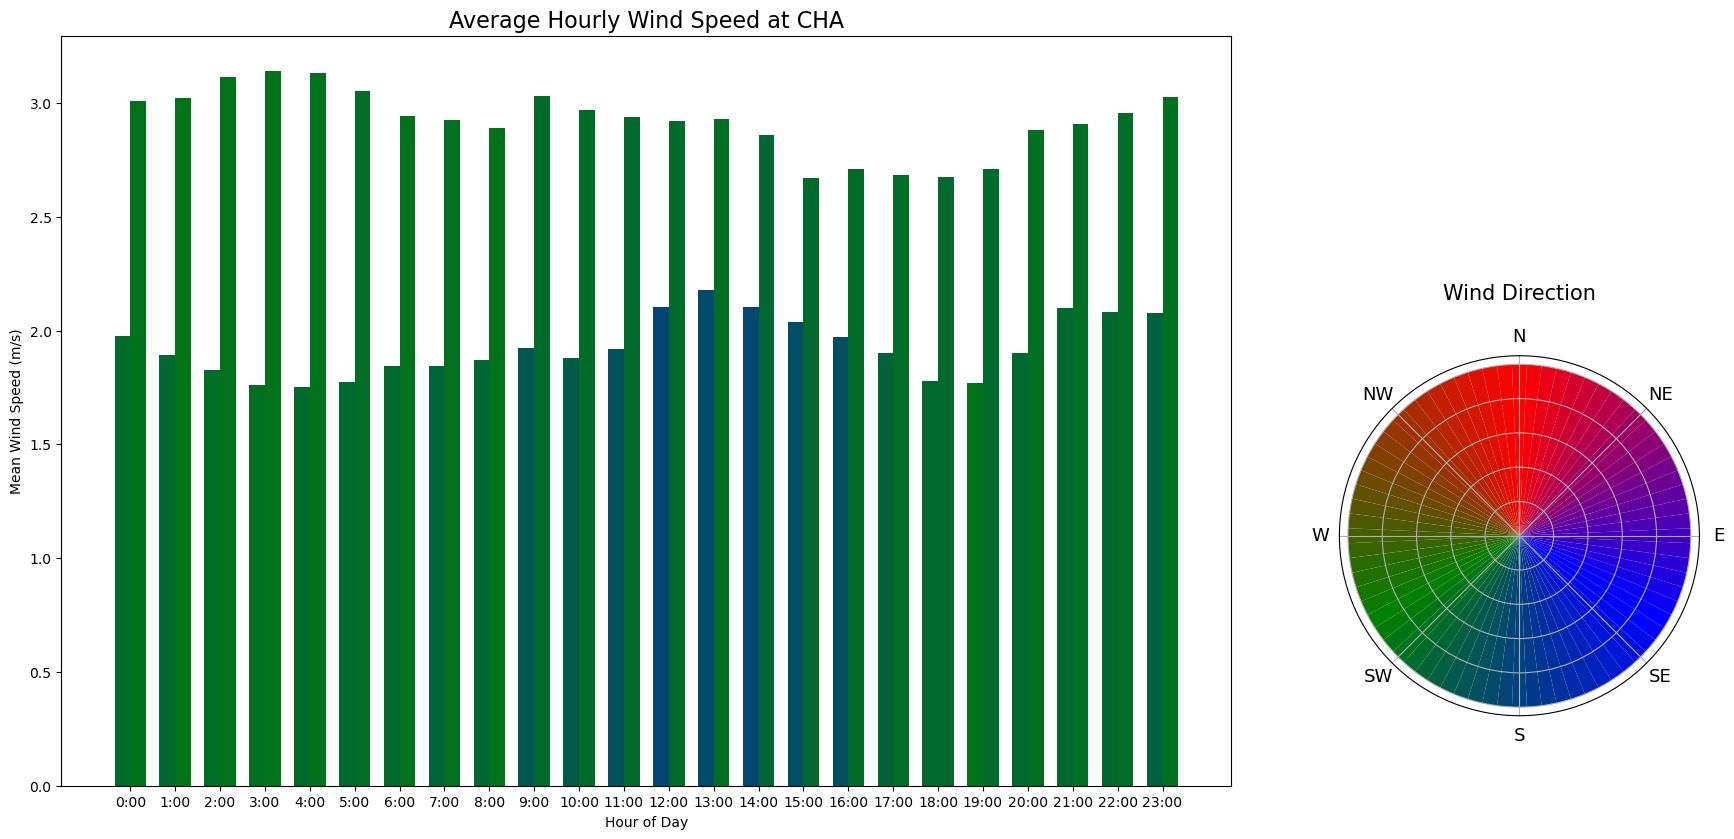

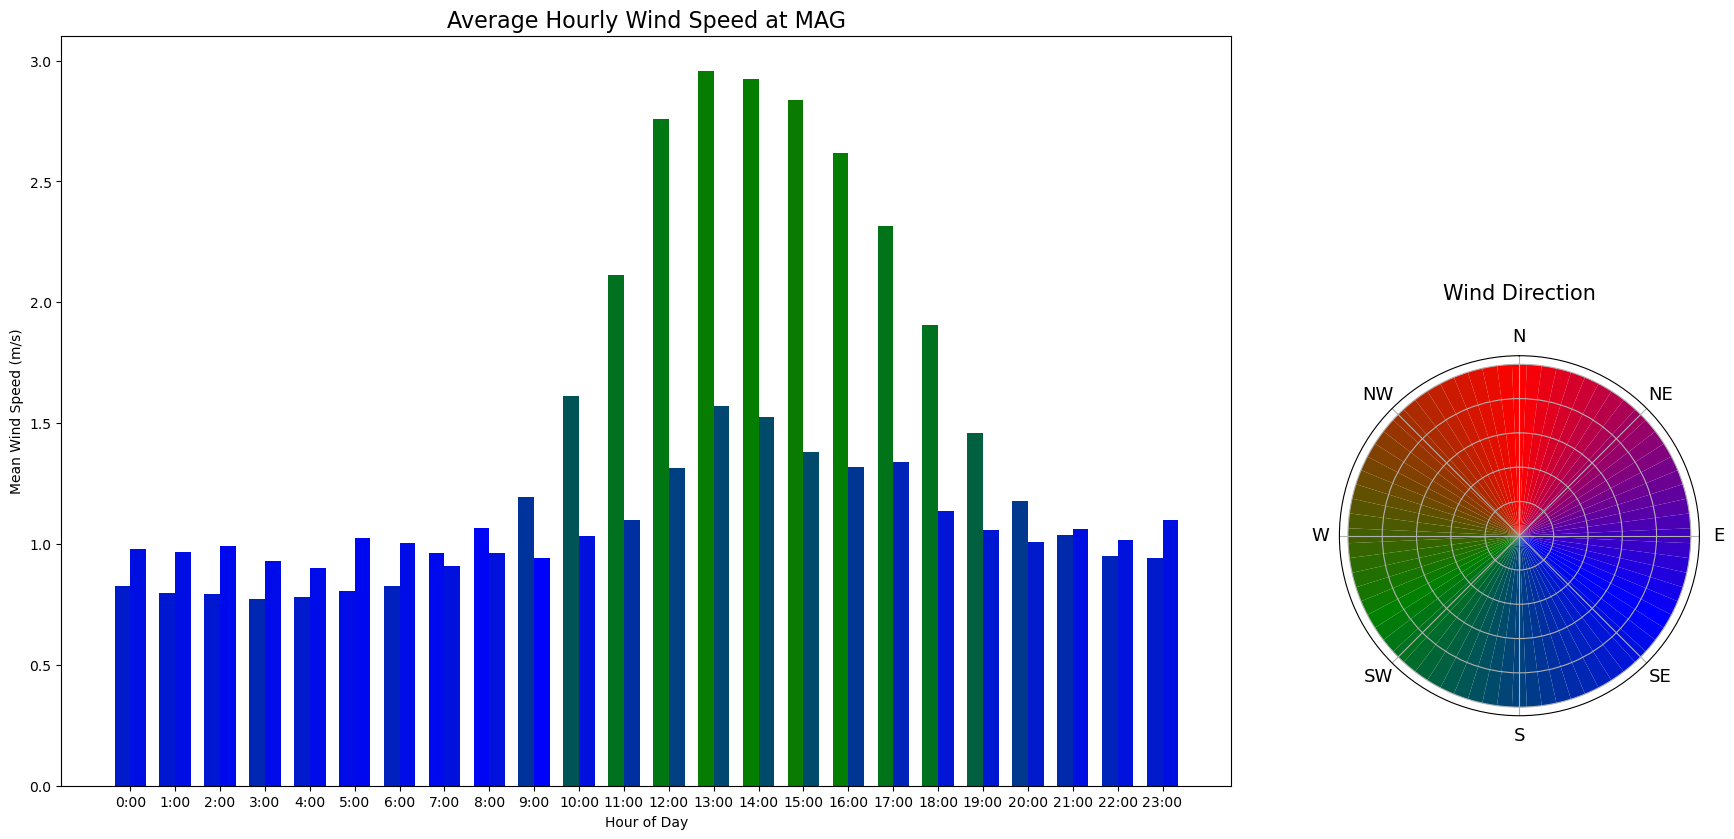

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# --- Load and prepare the data ---
file_path = 'Wind Speed and Direction.csv'  # Replace with your actual file path
df = pd.read_csv(file_path, delimiter=';')

# Fix decimal commas
for col in ['vCHA', 'vMAG']:
    df[col] = df[col].astype(str).str.replace(',', '.').astype(float)

df['time'] = pd.to_datetime(df['time'], format='%d.%m.%Y %H:%M')
df['Month'] = df['time'].dt.month
df['Hour'] = df['time'].dt.hour

# Define seasons
df['Season'] = np.where(df['Month'].isin([12, 1, 2]), 'Winter',
                        np.where(df['Month'].isin([6, 7, 8]), 'Summer', 'Other'))
df = df[df['Season'].isin(['Winter', 'Summer'])]  # Keep only winter and summer

# --- Color functions ---
def direction_to_color(direction_deg):
    """Map direction to RGB using circular colormap."""
    cmap = mcolors.LinearSegmentedColormap.from_list("wind_dir_cmap", ["red", "blue", "green", "red"])
    return cmap(direction_deg / 360)

# --- Plotting ---
for station in ['CHA', 'MAG']:
    fig = plt.figure(figsize=(18, 10))

    # Main bar plot
    ax = fig.add_axes([0.07, 0.15, 0.65, 0.75])  # [left, bottom, width, height]
    bar_width = 0.35
    x = np.arange(24)

    for season, offset_dir in zip(['Summer', 'Winter'], [-bar_width/2, bar_width/2]):
        season_data = df[df['Season'] == season]
        mean_speed = season_data.groupby('Hour')[f'v{station}'].mean()
        mean_direction = season_data.groupby('Hour')[f'd{station}'].mean()

        # Bar positions and colors
        x_pos = x + offset_dir
        bar_colors = [direction_to_color(d) for d in mean_direction]

        ax.bar(x_pos, mean_speed, width=bar_width, color=bar_colors)

    # Axis formatting
    ax.set_xticks(x)
    ax.set_xticklabels([f'{h}:00' for h in x])
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Mean Wind Speed (m/s)')
    ax.set_title(f'Average Hourly Wind Speed at {station}', fontsize=16)

    # --- Wind Direction Color Ring (Legend) ---
    legend_ax = fig.add_axes([0.78, 0.2, 0.2, 0.4], polar=True)  # [left, bottom, width, height]
    norm = mcolors.Normalize(0, 360)
    cmap = mcolors.LinearSegmentedColormap.from_list("wind_dir_cmap", ["red", "blue", "green", "red"])

    for angle in range(0, 360, 5):
        legend_ax.bar(np.deg2rad(angle), 1, width=np.deg2rad(5),
                      color=cmap(norm(angle)), edgecolor='none')

    # North facing up
    legend_ax.set_theta_zero_location("N")
    legend_ax.set_theta_direction(-1)

    legend_ax.set_yticklabels([])
    legend_ax.set_xticks(np.pi / 180. * np.linspace(0, 360, 8, endpoint=False))
    legend_ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'], fontsize=13)
    legend_ax.set_title('Wind Direction', fontsize=15, pad=20)

    plt.show()
